# NLP Modeling

With our clean and final data, we can finally begin modeling and test for our problem statement. As a reminder, my problem statement is to use NLP and binary classification models to determine whether or not the top five Fortune 100 companies have been changed how they communicate through press releases.

In the last notebook, I assigned the labels (i.e., before, after) based on the press release's publication date. Additionally, I cleaned the full text of the press releases by removing words that could potentially leak the target into my data (e.g., COVID, 2019, 2020, pandemic). It is with this clean data that I have created the below models help me determine whether or companies have changed how they communicate through press releases. 

Using binary classification models, if the models are able to beat the baseline (i.e., if they are better able to predict which class the press release falls into than randomly guessing), then there is a difference between press releases published before and after the pandemic that the machine learning models are able to determine.

For the purposes of this project, the null hypothesis, $H0$, is that there is no difference between press releases published before and after the start of the pandemic. The alternate hypothesis, $H1$, is that there is a difference between press releases published before and after the start of the pandemic.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics as metrics

# from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lang.en import English

import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
files = [f for f in os.listdir('../data/press_releases/') if 'csv' in f]

In [3]:
# concatenate all of the files into one DataFrame for modeling

df = pd.DataFrame()

for file in files:
    new = pd.read_csv(f'../data/press_releases/{file}')
    df = pd.concat([df,new],ignore_index=True)

df.head()

,full_link,title,body,html,date,full_text,year,label
0,https://www.apple.com/newsroom/2021/03/apple-e...,Apple earns historic Academy Award nominations...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,earns historic Academy Award nominations for ...,2021,after
1,https://www.apple.com/newsroom/2021/03/apple-w...,Apple Women’s Health Study releases preliminar...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Women’s Health Study releases preliminary dat...,2021,after
2,https://www.apple.com/newsroom/2021/03/apple-t...,Apple TV+ announces programming partnership wi...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,TV+ announces programming partnership with No...,2021,after
3,https://www.apple.com/newsroom/2021/03/apple-h...,Apple Hearing Study shares new insights on hea...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,Hearing Study shares new insights on hearing ...,2021,after
4,https://www.apple.com/newsroom/2021/03/new-zea...,New Zealand students prototype their own Samoa...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGlobal Nav...,"<!DOCTYPE html>\n<html class=""no-js"" dir=""ltr""...",2021-03-01,New Zealand students prototype their own Samoa...,2021,after


**Our baseline value, the one the models have to beat, is about 0.54 (0.539092).**

In [4]:
df.label.value_counts(normalize=True)

# baseline is 0.539092

after     0.539092
before    0.460908
Name: label, dtype: float64

## Vectorizing

I opted to use `spaCy` instead of `NLTK` for its speed and for its output readability. I was able to leverage code from [here](https://python.plainenglish.io/text-classification-using-python-spacy-7a414abcc83a) to build the model pipelines further below. I've made several adjustments to the code, such as using one of `spaCy`'s pre-trained models (saved to the variable `nlp`) as my parser.

In [5]:
# Create list of punctuation marks
punctuations = string.punctuation

# Create list of stopwords
stop_words = STOP_WORDS

# Create the parser
nlp = spacy.load('en_core_web_sm')

# Creating our tokenizer function
def spacy_tokenizer(text):
    # Creating our token object, which is used to create
    # documents with linguistic annotations.
    mytokens = nlp(text)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [
        word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in mytokens
    ]

    # Removing stop words
    mytokens = [
        word for word in mytokens
        if word not in stop_words and word not in punctuations
    ]

    # return preprocessed list of tokens
    return mytokens


# Custom transformer using spaCy
class predictors(TransformerMixin): 
    
    def transform(self, X, **transform_params):
        # Basic function to clean the text
        def clean_text(text):
            # Removing spaces and converting text into lowercase
            return text.strip().lower()
        
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

I've also opted to use `TfidfVectorizer` instead of `CountVectorizer` because it will score the words based on term frequency instead of a simple word count, scoring words used more frequently lower than those used less frequently in order to give more weight to the less frequently used words. 

In the instantiated `TfidfVectorizer` below, I have plugged in `spacy_tokenizer` into the tokenizer hyperparameter in order to use `spaCy`'s models in the process. I've also decided to use `strip_accents` to remove any characters that might be company specific from being overly weighted in the final result.

For `max_features`, I chose 4,000 as the maximum number of words that the program could use in order to get a larger number of features that the models can train on, without overloading the system. I've also chosen 0.2 and 0.8 as the lower (`min_df`) and upper (`max_df`) limits for document frequency to make sure that the model doesn't overtrain to any single word or ngram. I've also set the `ngram_range` to (1,2) to allow for any word pairings that may be important to be used for training the model. 

In [6]:
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,
                        strip_accents='unicode',
                        stop_words=stop_words,
                        max_features=4000,
                        max_df=.8,
                        min_df=.2,
                        ngram_range=(1, 2))

In [7]:
# set X and y
X = df['full_text']
y = df['label']

# train_test_split and add a random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=47,
                                                    stratify=y)

## Logistic Regression

As one of the most common classification models, I first wanted to test Logistic Regression to see what kind of results I could get. I started off with the penalty set to 'l2', which is the default for Logistic Regression.

From this model, we got a score of 0.65, which is well above the baseline of 0.54, an indication that there may be a discernible difference between our two categories of press releases. 

In [8]:
# Logistic Regression Classifier - penalty: 'l2'

logr = LogisticRegression(penalty='l2')

pipe_l2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('logr', logr)])

# model generation
pipe_l2.fit(X_train,y_train)
print('Train:', pipe_l2.score(X_train,y_train))
print('Test:', pipe_l2.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.7594617325483599
# Test: 0.654911838790932

Train: 0.7594617325483599
Test: 0.654911838790932


The below confusion matrix shows that the majority of press releases were correctly classified, and confirms the Logistic Regression model with an 'l2' penalty has an accuracy of 65%.

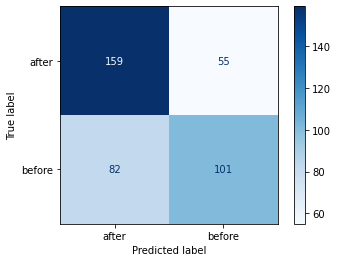

In [9]:
metrics.plot_confusion_matrix(pipe_l2, X_test, y_test, cmap='Blues', 
                              values_format='d');

The below ROC curve and the AUC score show that there is a moderate degree of separation between the two sets of press releases, as is discernible using the current model.

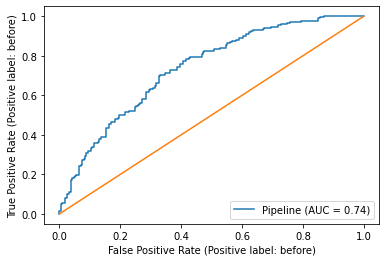

In [10]:
# ROC curve
metrics.plot_roc_curve(pipe_l2, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [11]:
metrics.roc_auc_score(y_test, pipe_l2.predict_proba(X_test)[:,1])

0.7365813799090957

After first testing Logistic Regression with an 'l2' penalty, I also wanted to test to see how Logistic Regression without a penalty would perform. In this case, without a penalty, while the model does perform slightly better, with an accuracy of 69%, and is still higher than our baseline, is it more significantly overfit to the training data and the model with the 'l2' penalty.

In [12]:
# Logistic Regression Classifier - penalty: 'none'

logr = LogisticRegression(penalty='none')

pipe_none = Pipeline([("cleaner", predictors()), 
                      ('vectorizer', tfidf),
                      ('logr', logr)])

# model generation
pipe_none.fit(X_train, y_train)
print('Train:', pipe_none.score(X_train, y_train))
print('Test:', pipe_none.score(X_test, y_test))

# baseline is 0.539092

# Train: 0.9217830109335576
# Test: 0.6952141057934509

Train: 0.9217830109335576
Test: 0.6952141057934509


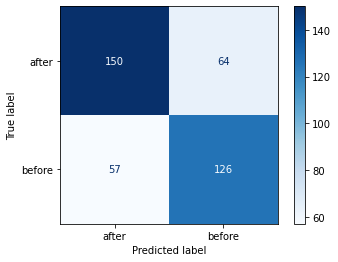

In [13]:
metrics.plot_confusion_matrix(pipe_none, X_test, y_test, cmap='Blues', 
                              values_format='d');

Additionally, although the model performed slightly better in terms of accuracy, the AUC score fell slightly from the model with the penalty, indicating slightly less of an ability to show separation between the two classes.

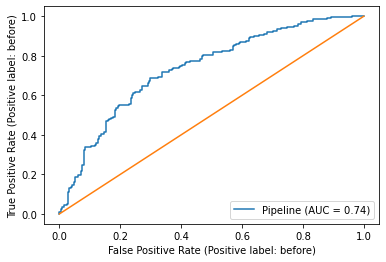

In [14]:
# ROC curve
metrics.plot_roc_curve(pipe_none, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [15]:
metrics.roc_auc_score(y_test, pipe_none.predict_proba(X_test)[:,1])

0.7356876564016139

## KNN

In addition to Logistic Regression, I also wanted to see how KNearest Neighbors (KNN) would perform on the data. Similar to how I started the Logistic Regression, I also started the KNN model off on the default, with n_neighbors set to 5. 

This model received an accuracy score of .71 on the test data, which means it is able to accurately predict the correct label on the test data 71% of the time. This is well above the baseline of .54, and is also higher than both of the Logistic Regression models. 

In [8]:
# KNN Classifier - Neighbors = 5

knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)

pipen5 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('knn', knn)])

# model generation
pipen5.fit(X_train,y_train)
print('Train:', pipen5.score(X_train,y_train))
print('Test:', pipen5.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.7821698906644239
# Test: 0.7128463476070529

Train: 0.7821698906644239
Test: 0.7128463476070529


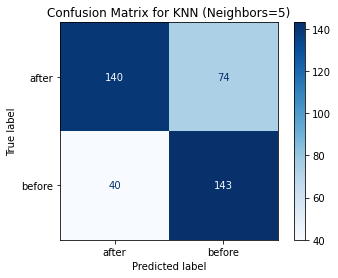

In [16]:
metrics.plot_confusion_matrix(pipen5, X_test, y_test, cmap='Blues', 
                              values_format='d')
plt.title('Confusion Matrix for KNN (Neighbors=5)')
plt.savefig('../assets/knn5_confusion_matrix.png')

Measuring the model's performance with the ROC curve and ROC-AUC score, with n_neighbors = 5, the model received a higher score than both of the Logistic Regression models as well, indicating that it's a better predictor than the other models. 

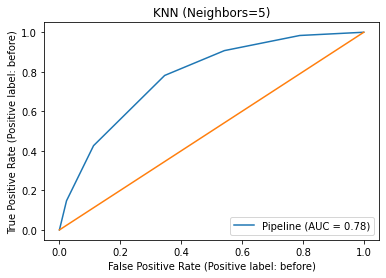

In [15]:
# ROC curve
metrics.plot_roc_curve(pipen5, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1])
plt.title('KNN (Neighbors=5)')
# plt.savefig('../assets/knn5_roc_curve.png')

In [23]:
metrics.roc_auc_score(y_test, pipen5.predict_proba(X_test)[:,1])

0.7766584954803125

After testing to see how well the default KNN model would perform, I wanted to see how increasing the number of n_neighbors would affect the model. I chose 8 as the next value for n_neighbors because it was higher than 5, but not so many that it would be too much for the computer to process. 

KNN with n_neighbors = 8 performed worse than n_neighbors = 5 on both the train and test data.

In [16]:
# KNN Classifier - Neighbors = 8

knn = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

pipen8 = Pipeline([("cleaner", predictors()), 
                   ('vectorizer', tfidf),
                   ('knn', knn)])

# model generation
pipen8.fit(X_train, y_train)
print('Train:', pipen8.score(X_train, y_train))
print('Test:', pipen8.score(X_test, y_test))

# baseline is 0.539092

# Train: 0.7493692178301093
# Test: 0.672544080604534

Train: 0.7493692178301093
Test: 0.672544080604534


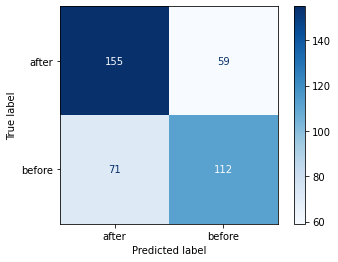

In [17]:
metrics.plot_confusion_matrix(pipen8, X_test, y_test, cmap='Blues', 
                              values_format='d');

Similarly, the n_neighbors = 8 model had a lower ROC-AUC score than the n_neighbors = 5 model.

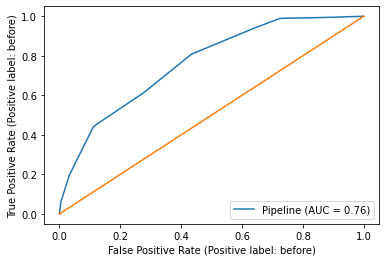

In [18]:
# ROC curve
metrics.plot_roc_curve(pipen8, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [19]:
metrics.roc_auc_score(y_test, pipen8.predict_proba(X_test)[:,1])

0.7631888054746949

Because increasing the number of n_neighbors ultimately hurt the performance of the model, I also wanted to test how choosing a value fewer than 5 would cause the model to perform. I chose 3 because it is both less than 5, but also seemed to still have enough data to help the model make a decision. 

The model with n_neighbors = 3 performed better on the train data but slightly worse on the test data, and also was overfit to the train data. However, at .71, the accuracy score for the test data was still well above the baseline of .54.

In [24]:
# KNN Classifier - Neighbors = 3

knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)

pipen3 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf),
                 ('knn', knn)])

# model generation
pipen3.fit(X_train,y_train)
print('Train:', pipen3.score(X_train,y_train))
print('Test:', pipen3.score(X_test,y_test))

# baseline is 0.539092

# Train: 0.8317914213624895
# Test: 0.707808564231738

Train: 0.8317914213624895
Test: 0.707808564231738


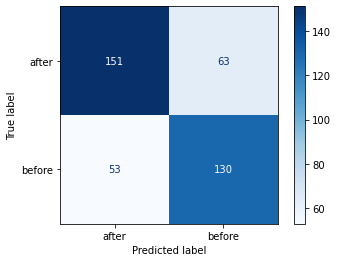

In [25]:
metrics.plot_confusion_matrix(pipen3, X_test, y_test, cmap='Blues', 
                              values_format='d');

Just as the n_neighbors = 3 model performed worse on the test data, it also scored lower on its ROC-AUC score than the n_neighbors = 5 model. 

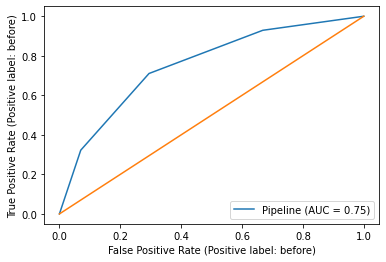

In [26]:
# ROC curve
metrics.plot_roc_curve(pipen3, X_test, y_test)
# add worst case scenario line
plt.plot([0, 1], [0, 1]);

In [27]:
metrics.roc_auc_score(y_test, pipen3.predict_proba(X_test)[:,1])

0.7535365915938921